## Plotting correlation between temperature and polarization



Set fiducial values of cosmological parameters to be set to `CAMB`



In [1]:
params = {
    "ombh2": 0.022, "omch2": 0.12, "H0": 68, "tau": 0.07,
    "As": 2.2e-9, "ns": 0.96,
    "mnu": 0.06, "nnu": 3.046, "num_massive_neutrinos": 1}

Let's put this dictionary of values into `cobaya` internal system of configuration



In [1]:
info = {
    "params": params,
    "likelihood": {"one": None},
    "theory": {"camb": None}
}

We will now get the model given the above parameters



In [1]:
from cobaya.model import get_model
camb_model = get_model(info)

Then set it to retrieve power spectra



In [1]:
lmin, lmax = 2, 3000
camb_model.likelihood.theory.needs(Cl={"tt": lmax, "te": lmax, "ee": lmax})

and compute the CMB power spectra (`ell_factor=True` means normalization by $\ell(\ell+1)/(2\pi)$)



In [1]:
camb_model.logposterior({})
Dls = camb_model.likelihood.theory.get_cl(ell_factor=False)

Finally, let's plot things between $(\ell_\text{min}, \ell_\text{max})$



# Out[6]:
Text(0, 0.5, '$R_{\\rm TT, EE}$')

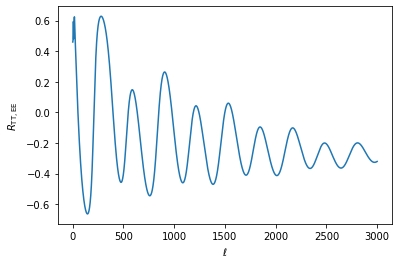

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

l = np.arange(lmin, lmax)
y = (Dls["te"]/np.sqrt(Dls["tt"]*Dls["ee"]))
plt.plot(l, y[lmin:lmax])
plt.xlabel(r"$\ell$")
plt.ylabel(r"$R_{\rm TT, EE}$")

## Plotting dependence to cosmological parameters



In [1]:
def plot_correlation(param_name="H0", amplitude=0.1):
    import matplotlib
    cmap = matplotlib.cm.get_cmap("RdBu_r")

    n = 10
    pars = np.linspace(params[param_name]*(1-amplitude),
                       params[param_name]*(1+amplitude), n)
    for i, p in enumerate(pars):
        from copy import deepcopy
        my_params = deepcopy(params)
        my_params[param_name] = p
        info = {
            "params": my_params,
            "likelihood": {"one": None},
            "theory": {"camb": None}
        }
        from cobaya.model import get_model
        camb_model = get_model(info)
        lmin, lmax = 2, 2000
        camb_model.likelihood.theory.needs(Cl={"tt": lmax, "te": lmax, "ee": lmax})
        camb_model.logposterior({})
        Dls = camb_model.likelihood.theory.get_cl(ell_factor=True)
        l = np.arange(lmin, lmax)
        y = (Dls["te"]/np.sqrt(Dls["tt"]*Dls["ee"]))[lmin:lmax]
        plt.plot(l, y, color=cmap(i/n))
    plt.xlabel(r"$\ell$")
    plt.ylabel(r"$R_{\rm TT, EE}$")
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=pars[0], vmax=pars[-1]))
    latex = {"ombh2": "$\Omega_\mathrm{b}h^2$",
             "omch2": "$\Omega_\mathrm{c}h^2$",
             "H0": "$H_0$ [km/s]",
             "tau": r"$\tau$",
             "As": "$A_\mathrm{s}$",
             "ns": "$n_\mathrm{s}$",
             "mnu": r"$m_\nu$"}
    plt.colorbar(sm, label=latex[param_name])

### H0



Varying H0 by &plusmn; 10% arrounf its fiducial value



# Out[55]:

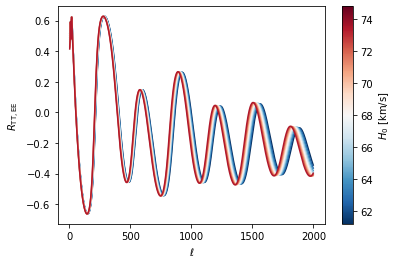

In [1]:
plot_correlation("H0")

### \Omega_{b}h^2



# Out[56]:

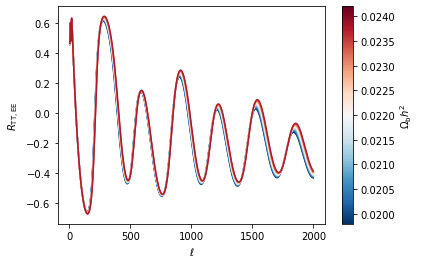

In [1]:
plot_correlation("ombh2")

### \Omega_{c}h^2



# Out[57]:

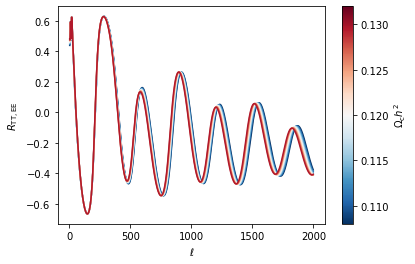

In [1]:
plot_correlation("omch2")

### \tau



# Out[61]:

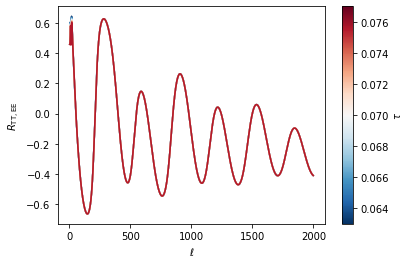

In [1]:
plot_correlation("tau")

### As



# Out[62]:

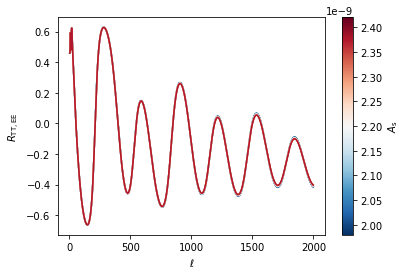

In [1]:
plot_correlation("As")

### ns



# Out[63]:

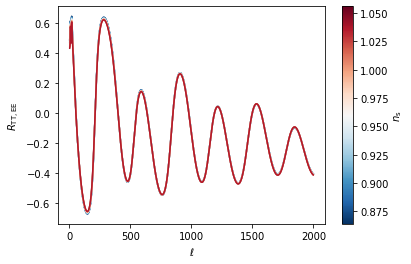

In [1]:
plot_correlation("ns")

### m_\nu



# Out[67]:

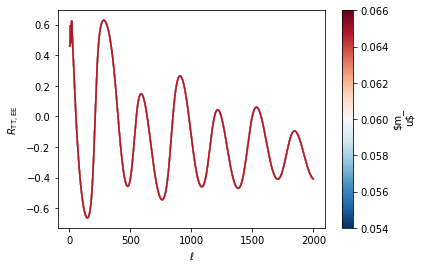

In [1]:
plot_correlation("mnu")

## Plotting variance of correlation coefficient



# Out[15]:

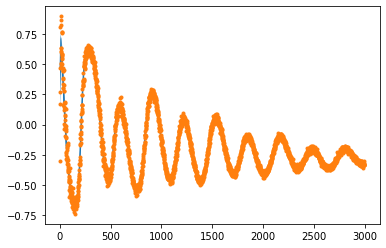

In [1]:
Rl = (Dls["te"]/np.sqrt(Dls["tt"]*Dls["ee"]))[lmin:lmax]
covmat = 1/(2*l+1)*(Rl**4-2*Rl**2+1)
plt.plot(l, Rl)
plt.fill_between(l, Rl-np.sqrt(covmat), Rl+np.sqrt(covmat))
Rl_obs = Rl + np.sqrt(covmat)*np.random.randn(np.alen(l))
plt.plot(l, Rl_obs, ".")

# Out[17]:

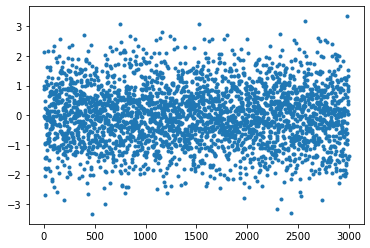

In [1]:
plt.plot(l, (Rl-Rl_obs)/np.sqrt(covmat), ".")

# Out[23]:

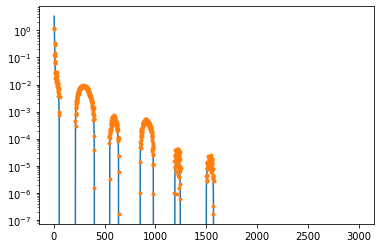

In [1]:
Cl_te = Dls["te"][lmin:lmax]
Cl_tt = Dls["tt"][lmin:lmax]
Cl_ee = Dls["ee"][lmin:lmax]
plt.semilogy(l, Cl_te)
covmat = 1/(2*l+1)*(Cl_tt*Cl_ee-Cl_te**2)
Cl_obs = Cl_te + np.sqrt(covmat)*np.random.randn(np.alen(l))
plt.plot(l, Cl_obs, ".")

# Out[24]:

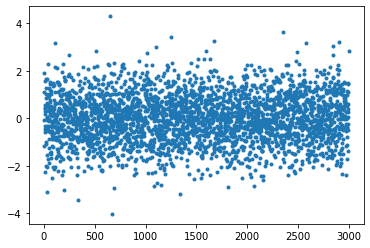

In [1]:
plt.plot(l, (Cl_te-Cl_obs)/np.sqrt(covmat), ".")

## SO noise



In [1]:
import numpy as np
import yaml
with open("../yaml/corrcoeff.yaml", "r") as stream:
    setup = yaml.load(stream, Loader=yaml.FullLoader)

# Get experiment setup
experiment = setup["experiment"]
fsky = experiment["fsky"]
lmin, lmax = 1, 8000
experiment["lmin"] = lmin
experiment["lmax"] = lmax
ells = np.arange(lmin, lmax)

Get SO noise



In [1]:
from corrcoeff import utils
modes = ["baseline", "goal"]
experiment["use"] = "SO"
SO = experiment["SO"]
SO["freq"] = SO["freq_all"]
N_TT, N_EE = {}, {}
for i, m in enumerate(modes):
  SO["sensitivity_mode"] = i+1
  N_TT[m], N_EE[m] = utils.get_noise(experiment)

Compute Cls for comparison



In [1]:
Cls = utils.get_theory_cls(setup, lmax)
Cl_TT = Cls["tt"][lmin:lmax]
Cl_TE = Cls["te"][lmin:lmax]
Cl_EE = Cls["ee"][lmin:lmax]

Plot everything together



# Out[4]:

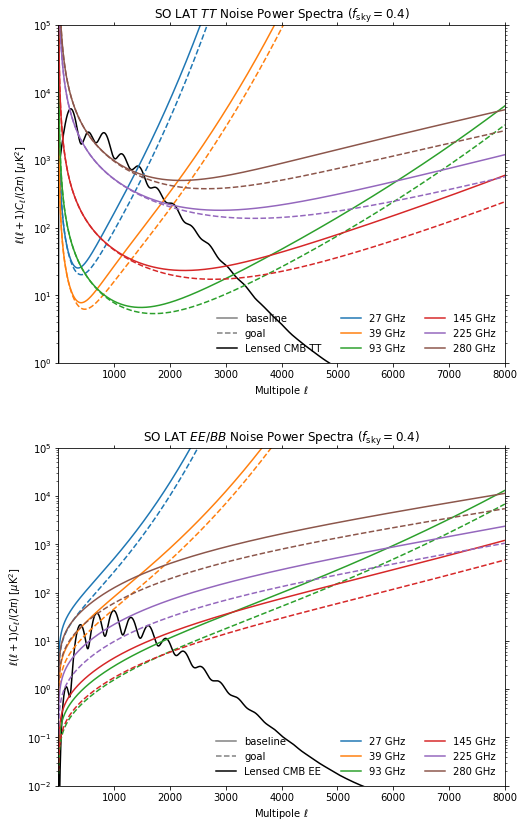

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["xtick.top"] = plt.rcParams["ytick.right"] = True

plt.figure(figsize=(8,14))
grid = plt.GridSpec(2, 1, hspace=0.25, wspace=0)

norm = ells*(ells+1)/(2*np.pi)

TT = plt.subplot(grid[0])
TT.semilogy()
TT.plot([], [], c="gray", ls="-", label="baseline")
TT.plot([], [], c="gray", ls="--", label="goal")
TT.plot(ells, norm*Cl_TT, "k", label="Lensed CMB TT")
EE = plt.subplot(grid[1])
EE.semilogy()
EE.plot([], [], c="gray", ls="-", label="baseline")
EE.plot([], [], c="gray", ls="--", label="goal")
EE.plot(ells, norm*Cl_EE, "k", label="Lensed CMB EE")

freqs = experiment["SO"]["freq_all"]
for i, f in enumerate(freqs):
  TT.plot(ells, norm*N_TT["baseline"][i], "-C{}".format(i), label="{} GHz".format(f))
  TT.plot(ells, norm*N_TT["goal"][i], "--C{}".format(i))
  EE.plot(ells, norm*N_EE["baseline"][i], "-C{}".format(i), label="{} GHz".format(f))
  EE.plot(ells, norm*N_EE["goal"][i], "--C{}".format(i))

TT.set_ylim(1, 10**5)
TT.set_xlim(lmin, lmax)
TT.set_title("SO LAT $TT$ Noise Power Spectra ($f_\mathrm{{sky}} = {}$)".format(fsky))
TT.set_ylabel("$\ell(\ell+1)C_\ell/(2\pi)~[\mu\mathrm{K}^2]$")
TT.set_xlabel("Multipole $\ell$")
TT.legend(ncol=3, loc="lower right")
EE.set_ylim(10**-2, 10**5)
EE.set_xlim(lmin, lmax)
EE.set_title(r"SO LAT $EE/BB$ Noise Power Spectra ($f_\mathrm{{sky}} = {}$)".format(fsky))
EE.set_ylabel("$\ell(\ell+1)C_\ell/(2\pi)~[\mu\mathrm{K}^2]$")
EE.set_xlabel("Multipole $\ell$")
EE.legend(ncol=3, loc="lower right")

Get Planck noise



In [1]:
from corrcoeff import utils
experiment["use"] = "Planck"
N_TT_pla, N_EE_pla = utils.get_noise(experiment)

# Out[23]:

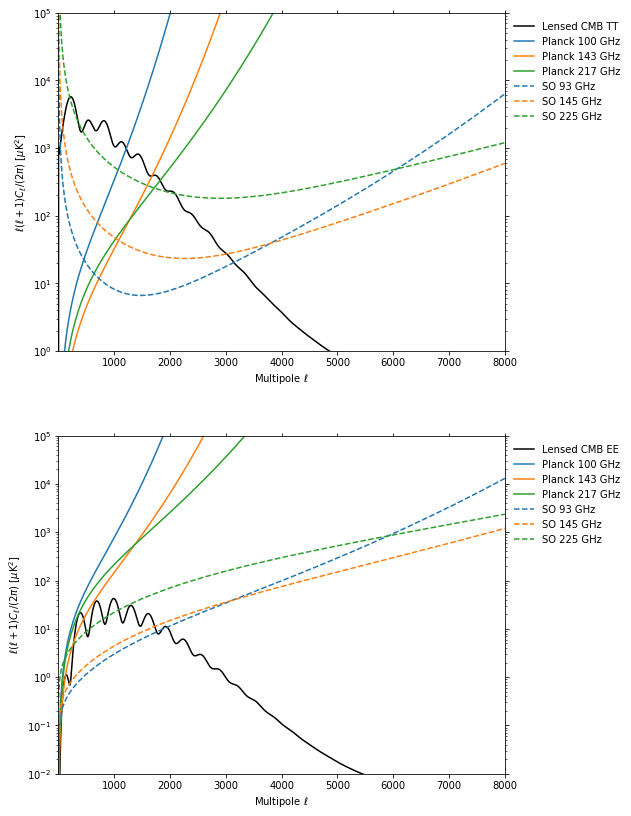

In [1]:
plt.figure(figsize=(8,14))
grid = plt.GridSpec(2, 1, hspace=0.25, wspace=0)

norm = ells*(ells+1)/(2*np.pi)

TT = plt.subplot(grid[0])
TT.semilogy()
TT.plot(ells, norm*Cl_TT, "k", label="Lensed CMB TT")
EE = plt.subplot(grid[1])
EE.semilogy()
EE.plot(ells, norm*Cl_EE, "k", label="Lensed CMB EE")

for i, f in enumerate([100, 143, 217]):
  TT.plot(ells, norm*N_TT_pla[i], "-C{}".format(i), label="Planck {} GHz".format(f))
  EE.plot(ells, norm*N_EE_pla[i], "-C{}".format(i), label="Planck {} GHz".format(f))
for i, f in enumerate([93, 145, 225]):
  TT.plot(ells, norm*N_TT["baseline"][i+2], "--C{}".format(i), label="SO {} GHz".format(f))
  EE.plot(ells, norm*N_EE["baseline"][i+2], "--C{}".format(i), label="SO {} GHz".format(f))

TT.set_ylim(1, 10**5)
TT.set_xlim(lmin, lmax)
TT.set_ylabel("$\ell(\ell+1)C_\ell/(2\pi)~[\mu\mathrm{K}^2]$")
TT.set_xlabel("Multipole $\ell$")
TT.legend(loc="upper left", bbox_to_anchor=(1,1))
EE.set_ylim(10**-2, 10**5)
EE.set_xlim(lmin, lmax)
EE.set_ylabel("$\ell(\ell+1)C_\ell/(2\pi)~[\mu\mathrm{K}^2]$")
EE.set_xlabel("Multipole $\ell$")
EE.legend(loc="upper left", bbox_to_anchor=(1,1))

## Fisher matrix for joint analysis



In [1]:
import yaml
with open("../yaml/corrcoeff.yaml", "r") as stream:
    setup = yaml.load(stream)

# Update cobaya setup
cparams = setup.get("cobaya").get("params")
params = [k for k, v in cparams.items() if isinstance(v, dict)
          and "prior" in v.keys() and "proposal" not in v.keys()]

# Out[23]:

In [1]:
import numpy as np
experiment = setup["experiment"]
lmin, lmax = experiment["lmin"], experiment["lmax"]
fsky = experiment["fsky"]

add_noise = True
nell = lmax - lmin

from corrcoeff import utils
if add_noise:
    # Get SO noise
    N_TT, N_EE = utils.get_noise(experiment)
    N_TT, N_EE = 1/np.sum(1/N_TT, axis=0), 1/np.sum(1/N_EE, axis=0)
else:
    N_TT = 0.0
    N_EE = 0.0
Cl = utils.get_theory_cls(setup, lmax)
C = np.array([[Cl["tt"][lmin:lmax] + N_TT, Cl["te"][lmin:lmax]],
              [Cl["te"][lmin:lmax], Cl["ee"][lmin:lmax] + N_EE]])
inv_C = np.empty_like(C)
for l in range(nell):
  inv_C[:,:,l] = np.linalg.inv(C[:,:,l])

# Out[49]:

In [1]:
from copy import deepcopy
epsilon = 0.01
deriv = np.empty((len(params), 2, 2, nell))
for i, p in enumerate(params):
    setup_mod = deepcopy(setup)
    parname = p if p != "logA" else "As"
    value = setup["simulation"]["cosmo. parameters"][parname]
    setup_mod["simulation"]["cosmo. parameters"][parname] = (1-epsilon)*value
    Cl_minus = utils.get_theory_cls(setup_mod, lmax)
    setup_mod["simulation"]["cosmo. parameters"][parname] = (1+epsilon)*value
    Cl_plus = utils.get_theory_cls(setup_mod, lmax)

    d = {}
    for s in ["tt", "te", "ee", "R"]:
        if s == "R":
            plus = Cl_plus["te"]/np.sqrt(Cl_plus["tt"]*Cl_plus["ee"])
            minus = Cl_minus["te"]/np.sqrt(Cl_minus["tt"]*Cl_minus["ee"])
        else:
            plus, minus = Cl_plus[s], Cl_minus[s]
        delta = (plus[lmin:lmax] - minus[lmin:lmax])/(2*epsilon*value)
        d[s] = delta if p != "logA" else delta*value

    deriv[i] = np.array([[d["tt"], d["te"]],
                         [d["te"], d["ee"]]])

# Out[50]:

In [1]:
deriv.shape, inv_C.shape

# Out[37]:
((5, 2, 2, 2950), (2, 2, 2950))

In [1]:
nparam = len(params)
fisher = np.empty((nparam,nparam))
ls = np.arange(lmin, lmax)

for p1 in range(nparam):
    for p2 in range(nparam):
        somme = 0.0
        for l in range(nell):
            m1 = np.dot(inv_C[:,:,l], deriv[p1,:,:,l])
            m2 = np.dot(inv_C[:,:,l], deriv[p2,:,:,l])
            somme += (2*ls[l]+1)/2*fsky*np.trace(np.dot(m1, m2))
        fisher[p1, p2] = somme
cov = np.linalg.inv(fisher)
print("eigenvalues = ", np.linalg.eigvals(cov))
for count, p in enumerate(params):
    if p == "logA":
        value = np.log(1e10*setup_mod["simulation"]["cosmo. parameters"]["As"])
    else:
        value = setup_mod["simulation"]["cosmo. parameters"][p]
    print(p, value, np.sqrt(cov[count,count]))

# print(cov)

# Out[51]:

-   TT with noise
    
    | cosmomc<sub>theta</sub>|0.0104085|3.2933741232560173e-06|
    | logA|3.044|0.0042968435366678845|
    | ns|0.9649|0.00419977568054334|
    | ombh2|0.02237|0.00011485252438054256|
    | omch2|0.1212|0.0014996312324999047|

-   TE with noise
    
    | cosmomc<sub>theta</sub>|0.0104085|1.8866899617573544e-06|
    | logA|3.044|0.005727651857143012|
    | ns|0.9649|0.004291586166845056|
    | ombh2|0.02237|0.00010732709115913571|
    | omch2|0.1212|0.0011281652102729464|

-   EE with noise
    
    | cosmomc<sub>theta</sub>|0.0104085|1.8381578861674736e-06|
    | logA|3.044|0.003972553996340056|
    | ns|0.9649|0.004709350724409364|
    | ombh2|0.02237|0.00014877990544718571|
    | omch2|0.1212|0.0010988558479663373|

-   TT<sub>TE</sub><sub>EE</sub> with noise
    
    | cosmomc<sub>theta</sub>|0.0104085|1.1402521162479395e-06|
    | logA|3.044|0.0022350121539707036|
    | ns|0.9649|0.0023879663777635067|
    | ombh2|0.02237|5.447897047605741e-05|
    | omch2|0.1212|0.0006342926186782754|



## Test new parameter a_pol



In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
params = {
    "ombh2": 0.022, "omch2": 0.122, "H0": 67.5, "tau": 0.06,
    "As": 2e-9, "ns": 0.965, "a_pol": 1.0}
info = {
    "params": params,
    "likelihood": {"one": None},
    "theory": {"camb": None}
}

In [1]:
from cobaya.model import get_model
camb_model = get_model(info)
lmin, lmax = 2, 3000
ls = np.arange(lmin, lmax)
camb_model.likelihood.theory.needs(Cl={"tt": lmax, "te": lmax, "ee": lmax})
camb_model.logposterior({})
Dls_ref = camb_model.likelihood.theory.get_Cl(ell_factor=False)

Plot spectra for different values of a<sub>pol</sub>



# Out[17]:
Text(0, 0.5, '$EE$')

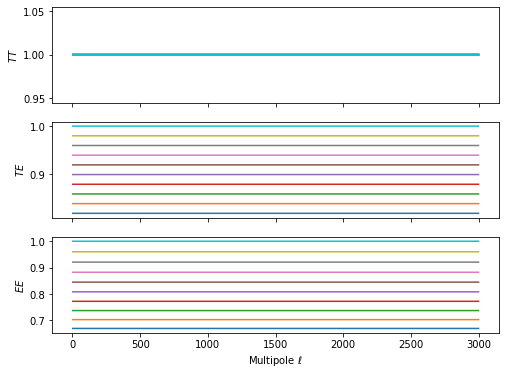

In [1]:
fig, ax = plt.subplots(3, 1, sharex="col", figsize=(8,6))
for a_pol in np.linspace(0.9, 1.1, 10):
    info["params"]["a_pol"] = a_pol
    camb_model = get_model(info)
    camb_model.likelihood.theory.needs(Cl={"tt": lmax, "te": lmax, "ee": lmax})
    camb_model.logposterior({})
    Dls = camb_model.likelihood.theory.get_Cl(ell_factor=False)
    for i, s in enumerate(["tt", "te", "ee"]):
        ax[i].plot(ls, Dls[s][lmin:lmax]/Dls_ref[s][lmin:lmax])
ax[-1].set_xlabel("Multipole $\ell$")
ax[0].set_ylabel("$TT$")
ax[1].set_ylabel("$TE$")
ax[2].set_ylabel("$EE$")

## Use homemade Pk



Load setup file



In [1]:
import yaml
with open("../yaml/corrcoeff.yaml", "r") as stream:
    setup = yaml.load(stream, Loader=yaml.FullLoader)

# Get experiment setup
experiment = setup["experiment"]
lmin, lmax = 2, 3000
experiment["lmin"] = lmin
experiment["lmax"] = lmax
ls = np.arange(lmin, lmax)

# Out[39]:

# Out[30]:

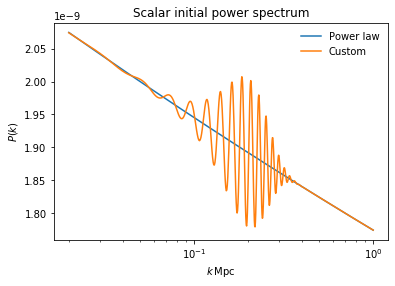

In [1]:
%matplotlib inline
import camb
import numpy as np
import matplotlib.pyplot as plt
#Let's look at some non-standard primordial power spectrum, e.g. with wavepacket oscillation

#Define our custom  power spectrum function (here power law with one wavepacket)
def PK(k, As, ns, amp, freq, wid, centre, phase):
    return As*(k/0.05)**(ns-1)*(1+ np.sin(phase+k*freq)*amp*np.exp(-(k-centre)**2/wid**2))

#Check how this looks compared to power law
freq = 280
ks = np.linspace(0.02,1,1000)
pk1 = 2e-9*(ks/0.05)**(0.96-1)
pk2 = PK(ks,2e-9, 0.96,0.0599, freq, 0.08, 0.2,0)
plt.semilogx(ks,pk1)
plt.semilogx(ks,pk2)
plt.ylabel('$P(k)$')
plt.xlabel(r'$k\, {\rm Mpc}$')
plt.legend(['Power law','Custom'])
plt.title('Scalar initial power spectrum');

# Out[40]:

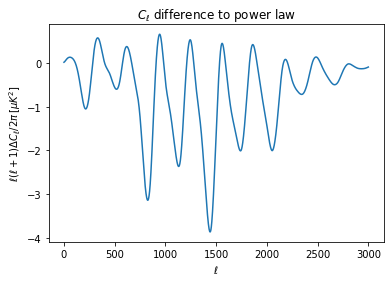

In [1]:
#Now compute C_l and compare
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122, tau=0.06)
pars.set_for_lmax(lmax,lens_potential_accuracy=1)

#For comparison, standard power law
pars.InitPower.set_params(As=2e-9, ns=0.96)
results = camb.get_results(pars)
cl_unlensed=results.get_unlensed_scalar_cls(CMB_unit ='muK')
cl=results.get_lensed_scalar_cls(CMB_unit ='muK')

#Not get custom spectrum (effective_ns_for_nonlinear is used for halofit if required)
pars.set_initial_power_function(PK, args=(2e-9, 0.96,0.0599, freq, 0.08, 0.2,0),
                                effective_ns_for_nonlinear=0.96)

results2 = camb.get_results(pars)
cl2_unlensed=results2.get_unlensed_scalar_cls(CMB_unit ='muK')
cl2=results2.get_lensed_scalar_cls(CMB_unit ='muK')

plt.plot(ls,(cl2[lmin:lmax,0]-cl[lmin:lmax,0]))
plt.xlabel(r'$\ell$');
plt.ylabel(r'$\ell(\ell+1)\Delta C_\ell/2\pi\, [\mu K^2]$')
plt.title(r'$C_\ell$ difference to power law');

Get SO and Planck noise



# Out[52]:

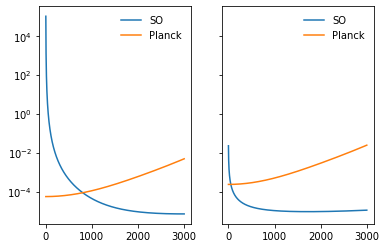

In [1]:
from corrcoeff import utils
N_TT, N_EE = {}, {}
use = ["SO", "Planck"]
fig, ax = plt.subplots(1, 2, sharey=True)
for i in use:
  experiment["use"] = i
  N_TT[i], N_EE[i] = utils.get_noise(experiment)
  N_TT[i], N_EE[i] = 1/np.sum(1/N_TT[i], axis=0), 1/np.sum(1/N_EE[i], axis=0)
  ax[0].semilogy(ls, N_TT[i], label=i)
  ax[1].semilogy(ls, N_EE[i], label=i)

ax[0].legend()
ax[1].legend()

# Out[50]:
Text(0.5, 0, 'Multipole $\\ell$')

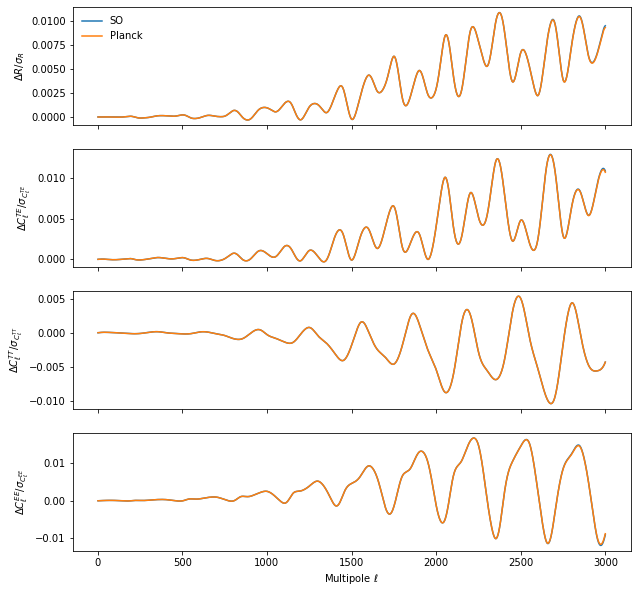

In [1]:
cl, cl2 = cl_unlensed, cl2_unlensed
Cl_TT, Cl_TE, Cl_EE = cl[lmin:lmax, 0], cl[lmin:lmax, 3], cl[lmin:lmax, 1]
R = Cl_TE/np.sqrt(Cl_TT*Cl_EE)
Cl_TT_pk, Cl_TE_pk, Cl_EE_pk = cl2[lmin:lmax, 0], cl2[lmin:lmax, 3], cl2[lmin:lmax, 1]
R_pk = Cl_TE_pk/np.sqrt(Cl_TT_pk*Cl_EE_pk)

fig, ax = plt.subplots(4, 1, sharex=True, figsize=(10, 10))
for i in use:
    covmat_RR   = R**4 - 2*R**2 + 1 + N_TT[i]/Cl_TT + N_EE[i]/Cl_EE + (N_TT[i]*N_EE[i])/(Cl_TT*Cl_EE) \
        + R**2*(0.5*(N_TT[i]/Cl_TT - 1)**2 + 0.5*(N_EE[i]/Cl_EE - 1)**2 - 1)
    covmat_TTTT = 2*(Cl_TT+N_TT[i])**2
    covmat_TETE = (Cl_TT+N_TT[i])*(Cl_EE+N_EE[i]) + Cl_TE**2
    covmat_EEEE = 2*(Cl_EE+N_EE[i])**2

    ax[0].plot(ls, (R_pk-R)/np.sqrt(covmat_RR), label=i)
    ax[1].plot(ls, (Cl_TE_pk-Cl_TE)/np.sqrt(covmat_TETE), label=i)
    ax[2].plot(ls, (Cl_TT_pk-Cl_TT)/np.sqrt(covmat_TTTT), label=i)
    ax[3].plot(ls, (Cl_EE_pk-Cl_EE)/np.sqrt(covmat_EEEE), label=i)

ax[0].legend()
ax[0].set_ylabel(r"$\Delta R/\sigma_R$")
ax[1].set_ylabel(r"$\Delta C_\ell^{TE}/\sigma_{C_\ell^{TE}}$")
ax[2].set_ylabel(r"$\Delta C_\ell^{TT}/\sigma_{C_\ell^{TT}}$")
ax[3].set_ylabel(r"$\Delta C_\ell^{EE}/\sigma_{C_\ell^{EE}}$")
ax[3].set_xlabel(r"Multipole $\ell$")

# Out[46]:

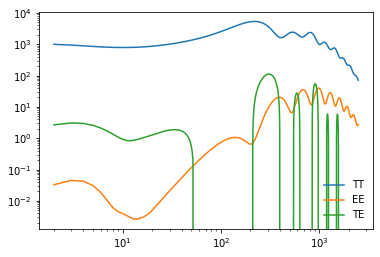

In [1]:
plt.plot(ls, cl[2:lmax,0], label="TT")
plt.plot(ls, cl[2:lmax,1], label="EE")
plt.plot(ls, cl[2:lmax,3], label="TE")
plt.yscale("log")
plt.xscale("log")
plt.legend()